# Statistical Tests

We want to know whether the difference between averages for differen HOLC grades is statistically significant. To do this we apply Student's t-test. This is designed to compare two different averages, so we compute the the significance between two HOLC grades at a time, giving a total of 3! tests.

The compares against the null hypothesis, which states there is not difference between the means. If the calculated t-value is greater than the t-value from the t-table (for your desired alpha), then the null hypothesis can be rejected. This implies that the differences between the populations did not happen by chance. 

We apply the equal variance independent T-Test. Assumptions of the test:

1. The data is normally distributed
2. The population variance in unknown, and the sample variances are approximately equal
3. The data leading to each mean are independent. *(There's no overlap in HOLC boundaries, so I think this holds.)*

## Data 

From each Landsat file, we have a set of median values for every HOLC boundary. We collect all of the median values for some HOLC grade for a set of decades, and label that as `dataset_holcX_decade1`. We create several datasets for each HOLC grade and decade and test whether the mean values of those are statistically significant. 

Data is imported from `02-data/summary_stats`. In this folder is a CSV file containing the mean, median, min, max, and standard deviation of the land surface temperature and NDVI for each Landsat file. They are named `stats_lst_...` or `stats_ndvi_...` where the ellipses refer to the original Landsat name. Each file contains a row for one HOLC boundary and the statistics associated with it. These files are imported here. 

## Next Steps

- [ ] Add a column to the t-value table that contains degrees of freedom
- [ ] Plot HOLC C over time 

# Student's T-test

In [1]:
import os
DIR_PARENT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIR_SCRIPTS = DIR_PARENT + "/01-scripts"

"""Push directory to helper scripts from"""
import sys
sys.path.append(DIR_SCRIPTS)
import helpers

import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

DIR_PARENT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIR_DATA = DIR_PARENT + "/02-data"
DIR_STATS = DIR_DATA + "/summary_stats"

# fnames_stats is a list of all the filenames
fnames_stats = []
helpers.get_filenames(DIR_STATS, fnames_stats)
fnames_stats_lst = [x for x in fnames_stats if "lst" in x]
fnames_states_ndvi = [x for x in fnames_stats if "ndvi" in x]


# The year ranges we choose for grouping the data
year_ranges = [(1984,1993), (1994,2002), (2003, 2012), (2013,2022)]

def parse_date_fname(fname):
    return pd.to_datetime(fname.split("_")[7])

def datetime_year(y): 
    return pd.to_datetime("1Jan"+str(y))

landsat_dates = [parse_date_fname(x) for x in fnames_stats_lst]

In [2]:
yr = 0
fnames_yr0 = [x for x in fnames_stats_lst if 
         parse_date_fname(x) <= datetime_year(year_ranges[yr][1]) and
         parse_date_fname(x) >= datetime_year(year_ranges[yr][0])]

yr = 1
fnames_yr1 = [x for x in fnames_stats_lst if 
         parse_date_fname(x) <= datetime_year(year_ranges[yr][1]) and
         parse_date_fname(x) >= datetime_year(year_ranges[yr][0])]

yr = 2
fnames_yr2 = [x for x in fnames_stats_lst if 
         parse_date_fname(x) <= datetime_year(year_ranges[yr][1]) and
         parse_date_fname(x) >= datetime_year(year_ranges[yr][0])]

yr = 3
fnames_yr3 = [x for x in fnames_stats_lst if 
         parse_date_fname(x) <= datetime_year(year_ranges[yr][1]) and
         parse_date_fname(x) >= datetime_year(year_ranges[yr][0])]


print("Number of Landsat files in the range 0 = ", len(fnames_yr0))
print("Number of Landsat files in the range 1 = ", len(fnames_yr1))
print("Number of Landsat files in the range 2 = ", len(fnames_yr2))
print("Number of Landsat files in the range 3 = ", len(fnames_yr3))

def import_and_combine(fnames_list):   
    """Import the files to one pandas dataframe """
    df = pd.read_csv(fnames_list[0])
    for fname in fnames_list[1:]:
        df_next = pd.read_csv(fname)
        df = pd.concat([df, df_next])
    return df

df_yr0 = import_and_combine(fnames_yr0)
df_yr1 = import_and_combine(fnames_yr1)
df_yr2 = import_and_combine(fnames_yr2)
df_yr3 = import_and_combine(fnames_yr3)

Number of Landsat files in the range 0 =  26
Number of Landsat files in the range 1 =  26
Number of Landsat files in the range 2 =  33
Number of Landsat files in the range 3 =  21


## Assumption 1: Normal distribution of the data

Below we plot a histogram of the data used to compute the mean LST for each HOLC grade. We compute the mean and standard deviation, and overlay a Gaussian curve to visually test whether the data is normally distributed. 

Mean LST =  299.5480358906281
Stdev LST =  3.133421378833548


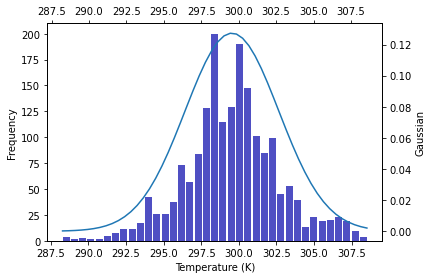

In [27]:
data_choice = df_yr1 # OPTIONS: df_yr0, df_yr1, df_yr2, df_yr3
holc_choice = "B" # OPTIONS: A, B, C, D
stat_choice = "median" # OPTIONS: "mean", "median", "min", "max", "stdev"

#########################################################################
data_to_test = data_choice[data_choice["holc_grade"]==
                               holc_choice][stat_choice]

fig, ax = plt.subplots(1,1)

ax2 = ax.twinx()
ax3 = ax2.twiny()

ax.hist(x=data_to_test, bins='auto', 
        color='#0504aa', alpha=0.7, rwidth=0.85)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Frequency")

"""Make Gasssian plot"""
avg_data = np.mean(data_to_test)
std_data = np.std(data_to_test)
xgauss = np.linspace(np.min(data_to_test),np.max(data_to_test),50)
ygauss = [(1/(std_data*np.sqrt(2*np.pi)))*np.exp(
            -(x-avg_data)**2/(2*std_data**2)) for x in xgauss]

ax3.plot(xgauss, ygauss)
ax2.set_ylabel("Gaussian")

print("Mean LST = ", avg_data)
print("Stdev LST = ", std_data)

## Assumption 2: Variances are the same

Calculating the variance of each data set, we indeed find that they're about the same within one year, but they are not the same in between years. 

In [24]:
lst_stats = df_yr2 # OPTIONS: df_yr0, df_yr1, df_yr2, df_yr3
stat_choice = "median" # OPTIONS: "mean", "median", "min", "max", "stdev"

######################################################################
lst_a = lst_stats[(lst_stats["holc_grade"]=="A")][stat_choice]
lst_b = lst_stats[(lst_stats["holc_grade"]=="B")][stat_choice]
lst_c = lst_stats[(lst_stats["holc_grade"]=="C")][stat_choice]
lst_d = lst_stats[(lst_stats["holc_grade"]=="D")][stat_choice]

print("Variance of HOLC A = ", np.var(lst_a))
print("Variance of HOLC B = ", np.var(lst_b))
print("Variance of HOLC C = ", np.var(lst_c))
print("Variance of HOLC D = ", np.var(lst_d))

Variance of HOLC A =  21.654104496448173
Variance of HOLC B =  21.014607809770713
Variance of HOLC C =  21.28823934067674
Variance of HOLC D =  24.34954566747236


## Compute t-values

Below we compute the t-values between pairs of HOLC grades. In this way, we test for independence of means between HOLC A and HOLC B, HOLC A and HOLC C, etc. 

We use `scipy`'s `ttest_ind` function. The documentation gives the following description of this function. 

    Calculate the T-test for the means of two independent samples of scores.

    This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.
    
This can be avoided by setting the parameter `equal_var=False`.

In [25]:
stat_choice = "median" # OPTIONS: "mean", "median", "min", "max", "stdev"

############################################################################
def intrayear_tstat(df_yr, holc1, holc2):
    """
    Compute the intra-year t-statistic. This means that the statistiic
    is computed between means of the same year range and different grades.
    """
    return stats.ttest_ind(
            df_yr[(df_yr["holc_grade"]==holc1)][stat_choice].dropna(), 
            df_yr[(df_yr["holc_grade"]==holc2)][stat_choice].dropna(), 
            equal_var=False)

stat_df = pd.DataFrame(columns=["t-value","p-value"],
                      index=["yr0a_yr0b"])

stat_df.loc["yr0a_yr0b"] = intrayear_tstat(df_yr0, "A", "B")
stat_df.loc["yr0a_yr0c"] = intrayear_tstat(df_yr0, "A", "C")
stat_df.loc["yr0a_yr0d"] = intrayear_tstat(df_yr0, "A", "D")
stat_df.loc["yr0b_yr0c"] = intrayear_tstat(df_yr0, "B", "C")
stat_df.loc["yr0b_yr0d"] = intrayear_tstat(df_yr0, "B", "D")
stat_df.loc["yr0c_yr0d"] = intrayear_tstat(df_yr0, "C", "D")

stat_df.loc["yr1a_yr1b"] = intrayear_tstat(df_yr1, "A", "B")
stat_df.loc["yr1a_yr1c"] = intrayear_tstat(df_yr1, "A", "C")
stat_df.loc["yr1a_yr1d"] = intrayear_tstat(df_yr1, "A", "D")
stat_df.loc["yr1b_yr1c"] = intrayear_tstat(df_yr1, "B", "C")
stat_df.loc["yr1b_yr1d"] = intrayear_tstat(df_yr1, "B", "D")
stat_df.loc["yr1c_yr1d"] = intrayear_tstat(df_yr1, "C", "D")

stat_df.loc["yr2a_yr2b"] = intrayear_tstat(df_yr2, "A", "B")
stat_df.loc["yr2a_yr2c"] = intrayear_tstat(df_yr2, "A", "C")
stat_df.loc["yr2a_yr2d"] = intrayear_tstat(df_yr2, "A", "D")
stat_df.loc["yr2b_yr2c"] = intrayear_tstat(df_yr2, "B", "C")
stat_df.loc["yr2b_yr2d"] = intrayear_tstat(df_yr2, "B", "D")
stat_df.loc["yr2c_yr2d"] = intrayear_tstat(df_yr2, "C", "D")

stat_df.loc["yr3a_yr3b"] = intrayear_tstat(df_yr3, "A", "B")
stat_df.loc["yr3a_yr3c"] = intrayear_tstat(df_yr3, "A", "C")
stat_df.loc["yr3a_yr3d"] = intrayear_tstat(df_yr3, "A", "D")
stat_df.loc["yr3b_yr3c"] = intrayear_tstat(df_yr3, "B", "C")
stat_df.loc["yr3b_yr3d"] = intrayear_tstat(df_yr3, "B", "D")
stat_df.loc["yr3c_yr3d"] = intrayear_tstat(df_yr3, "C", "D")


# """Add a column for the degrees of freedom"""
# dof = [len(lst_a)+len(lst_b)-2,
#         len(lst_a)+len(lst_c)-2,
#         len(lst_a)+len(lst_d)-2,
#         len(lst_b)+len(lst_c)-2,
#         len(lst_b)+len(lst_d)-2,
#         len(lst_c)+len(lst_d)-2]
# stat_df["degrees-of-freedom"] = dof

# Print the table
stat_df 

,t-value,p-value
yr0a_yr0b,-7.30086,8.67596e-13
yr0a_yr0c,-11.0092,2.17744e-25
yr0a_yr0d,-10.6272,3.8554e-24
yr0b_yr0c,-5.87845,4.52938e-09
yr0b_yr0d,-5.25824,1.52864e-07
yr0c_yr0d,0.186001,0.85245
yr1a_yr1b,-8.86832,8.0172e-18
yr1a_yr1c,-15.1142,1.35378e-42
yr1a_yr1d,-15.1998,1.0011e-43
yr1b_yr1c,-10.6809,3.29038e-26


In [16]:
stat_choice = "median" # OPTIONS: "mean", "median", "min", "max", "stdev"

############################################################################

stat_df = pd.DataFrame(columns=["t-value","p-value"],
                      index=["yr0a_yr1a"])

def intragrade_tstat(df1, df2, holc):
    """
    Compute the intra-grade t-statistic. This means that the statistiic
    is computed between means of the same grade and different year
    ranges.
    """
    return stats.ttest_ind(
            df1[(df1["holc_grade"]==holc)][stat_choice].dropna(), 
            df2[(df2["holc_grade"]==holc)][stat_choice].dropna(), 
            equal_var=False)

print(intragrade_tstat(df_yr0, df_yr1, "A"))

stat_df.loc["yr0a_yr1a"] = intragrade_tstat(df_yr0, df_yr1, "A")
stat_df.loc["yr0a_yr2a"] = intragrade_tstat(df_yr0, df_yr2, "A")
stat_df.loc["yr0a_yr3a"] = intragrade_tstat(df_yr0, df_yr3, "A")

stat_df.loc["yr0b_yr1b"] = intragrade_tstat(df_yr0, df_yr1, "B")
stat_df.loc["yr0b_yr2b"] = intragrade_tstat(df_yr0, df_yr2, "B")
stat_df.loc["yr0b_yr3b"] = intragrade_tstat(df_yr0, df_yr3, "B")

stat_df.loc["yr0c_yr1c"] = intragrade_tstat(df_yr0, df_yr1, "C")
stat_df.loc["yr0c_yr2c"] = intragrade_tstat(df_yr0, df_yr2, "C")
stat_df.loc["yr0c_yr3c"] = intragrade_tstat(df_yr0, df_yr3, "C")

stat_df.loc["yr0d_yr1d"] = intragrade_tstat(df_yr0, df_yr1, "D")
stat_df.loc["yr0d_yr2d"] = intragrade_tstat(df_yr0, df_yr2, "D")
stat_df.loc["yr0d_yr3d"] = intragrade_tstat(df_yr0, df_yr3, "D")

stat_df.loc["yr1a_yr2a"] = intragrade_tstat(df_yr1, df_yr2, "A")
stat_df.loc["yr1a_yr3a"] = intragrade_tstat(df_yr1, df_yr3, "A")

stat_df.loc["yr1b_yr2b"] = intragrade_tstat(df_yr1, df_yr2, "B")
stat_df.loc["yr1b_yr3b"] = intragrade_tstat(df_yr1, df_yr3, "B")

stat_df.loc["yr1c_yr2c"] = intragrade_tstat(df_yr1, df_yr2, "C")
stat_df.loc["yr1c_yr3c"] = intragrade_tstat(df_yr1, df_yr3, "C")

stat_df.loc["yr1d_yr2d"] = intragrade_tstat(df_yr1, df_yr2, "D")
stat_df.loc["yr1d_yr3d"] = intragrade_tstat(df_yr1, df_yr3, "D")

stat_df.loc["yr2a_yr3a"] = intragrade_tstat(df_yr2, df_yr3, "A")

stat_df.loc["yr2b_yr3b"] = intragrade_tstat(df_yr2, df_yr3, "B")

stat_df.loc["yr2c_yr3c"] = intragrade_tstat(df_yr2, df_yr3, "C")

stat_df.loc["yr2d_yr3d"] = intragrade_tstat(df_yr2, df_yr3, "D")

# """Add a column for the degrees of freedom"""
# dof = [len(lst_a)+len(lst_b)-2,
#         len(lst_a)+len(lst_c)-2,
#         len(lst_a)+len(lst_d)-2,
#         len(lst_b)+len(lst_c)-2,
#         len(lst_b)+len(lst_d)-2,
#         len(lst_c)+len(lst_d)-2]
# stat_df["degrees-of-freedom"] = dof

# Print the table
stat_df

Ttest_indResult(statistic=2.412762004047488, pvalue=0.016067958403956133)


,t-value,p-value
yr0a_yr1a,2.41276,0.016068
yr0a_yr2a,-2.92391,0.00354137
yr0a_yr3a,-9.9699,4.53984e-22
yr0b_yr1b,6.59109,5.04841e-11
yr0b_yr2b,-2.89193,0.00384916
yr0b_yr3b,-16.9243,9.78341e-62
yr0c_yr1c,8.0211,1.18574e-15
yr0c_yr2c,-7.75226,9.85862e-15
yr0c_yr3c,-30.564,4.38958e-195
yr0d_yr1d,5.23284,1.73104e-07
